In [2]:
import rosbag
import numpy as np
import sys
import csi_utils.constants as constants
import csi_utils.transform_utils as transform_utils
import csi_utils.pipeline_utils as pipeline_utils
import csi_utils.comp_utils as comp_utils
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.cm import ScalarMappable
# import mne
import tqdm
# import cv2

In [3]:
# Define variables to store your data
comp0 = np.load("./tx0-192.168.43.1-157.npy")
comp = np.load("./tx2-192.168.43.1-157.npy")
apply_nts = True
idx = 0
valid_tx_ant = [0,1,2,3]
# mne.beamformer.rap_music()

In [4]:
#open the experiment1 folder and read all the files into a list
from os import listdir
files = listdir("./csiTesting/experiment1")
files = [file for file in files if file.endswith(".bag")]
bags = [rosbag.Bag(f"./csiTesting/experiment1/{file}") for file in files]
positions = []
for file in files:
  strs = file.split("_")
  strs[3] = strs[3].split(".")[0]
  positions.append([int(strs[1]), int(strs[2]), int(strs[3])])
positions


[[-3, 1, 0],
 [-1, 0, 0],
 [-2, 1, 0],
 [-1, 2, 0],
 [-3, 0, 0],
 [-2, 2, 0],
 [-1, 1, 0],
 [-2, 0, 0],
 [0, 0, 0],
 [0, 1, 0],
 [0, 2, 0],
 [0, 0, 0]]

213it [00:00, 3543.96it/s]


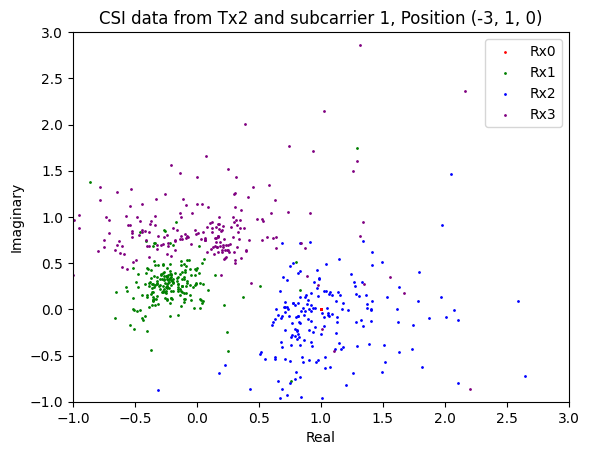

In [5]:
bag1 = rosbag.Bag("./csiTesting/experiment1/CSI_-1_0_0.bag")
bag2 = rosbag.Bag("./csiTesting/experiment1/CSI_-2_0_0.bag")
bag3 = rosbag.Bag("./csiTesting/experiment1/CSI_-3_0_0.bag")
bag4 = rosbag.Bag("./csiTesting/experiment1/CSI_-1_1_0.bag")
bag4 = rosbag.Bag("./csiTesting/experiment1/CSI_-1_1_0.bag")
bag4 = rosbag.Bag("./csiTesting/experiment1/CSI_-1_1_0.bag")
bag4 = rosbag.Bag("./csiTesting/experiment1/CSI_-1_1_0.bag")
def plot_csi_data_complex(bag, tx, subcarrier, title=None, saveName=None):
  allData = {0: [[], []], 1: [[], []], 2: [[], []], 3: [[], []]}
  colors = ["red", "green", "blue", "purple"]
  fig, ax = plt.subplots()
  ax.set(xlim=(-1, 3), ylim=(-1, 3))
  if title == None:
    title = f"CSI data from Tx{tx} and subcarrier {subcarrier}"
  plt.title(title)
  plt.ylabel("Imaginary")
  plt.xlabel("Real")
  num = 0
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      # print(np.shape(csi))
      benchmark = csi[subcarrier, 0, tx]
      for i in range(0, 4):
          data = csi[subcarrier, i, tx] / benchmark
          allData[i][0].append(data.real)
          allData[i][1].append(data.imag)
      num += 1
            # print(np.abs(csi[subcarrier, i, j]))
      # return
  for i in range(0, 4):
    ax.scatter(allData[i][0], allData[i][1], c=colors[i], label=f"Rx{i}", s=1)
  # ax.scatter(reals, imags, c=colors * num, s=1)
  ax.legend()
  if (saveName == None):
    plt.show()
  else:
    plt.savefig(saveName)
# plot_csi_data_complex(bag1, 2, 1, title=f"CSI data from Tx{2} and subcarrier {1}, Position (-1, 0, 0)")
# plot_csi_data_complex(bag2, 2, 1, title=f"CSI data from Tx{2} and subcarrier {1}, Position (-2, 0, 0)")
# plot_csi_data_complex(bag4, 2, 1, title=f"CSI data from Tx{2} and subcarrier {1}, Position (-3, 0, 0)")
i = 0
pos = positions[i]
plot_csi_data_complex(bags[i], 2, 1, title=f"CSI data from Tx{2} and subcarrier {1}, Position ({pos[0]}, {pos[1]}, {pos[2]})")
# plot_csi_data(bag2, 2, 1)
# for i in range(0, 49):
  # plot_csi_data(bag1, 2, i, f"./csiTesting/normalizedImages/subcarrier{i}.png")

179it [00:00, 4010.58it/s]


SHOWING1


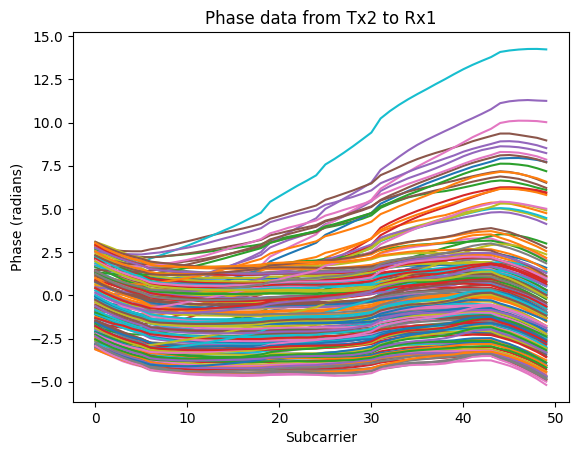

In [6]:
def plot_phase_data(data, tx, rx, normalize=False, ax=None, color='green', title=None, saveName=None, **kwargs):
  allData = {0: [[], []], 1: [[], []], 2: [[], []], 3: [[], []]}
  colors = ["red", "green", "blue", "purple"]
  newplot = False
  if ax == None:
    fig, ax = plt.subplots()
    newplot = True
  if title == None:
    title = f"Phase data from Tx{tx} to Rx{rx}"
  ax.set_title(title)
  if 'xlabel' not in kwargs.keys() or kwargs['xlabel']:
    ax.set_xlabel("Subcarrier")
  if 'ylabel' not in kwargs.keys() or kwargs['ylabel']:
    ax.set_ylabel("Phase (radians)")
  num = 0
  for csi, t in data:
      subcarriers = np.arange(0, 50)
      phases = []
      for subcarrier in range(0, 50):
        benchmark = csi[subcarrier, 0, tx]
        data = csi[subcarrier, rx, tx]
        if normalize:
           data /= benchmark
        phase = np.angle(data)
        phases.append(phase)
      ax.plot(subcarriers, np.unwrap(phases), alpha=1)
      num += 1
  if (saveName == None and newplot):
    print("SHOWING1")
    plt.show()
  elif saveName != None:
    plt.savefig(saveName)

def plot_phase(bag, tx, rx, normalize=False, ax=None, color='green', title=None, saveName=None):
  data = []
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      data.append((pipeline_utils.extract_csi(msg), t))
  plot_phase_data(data, tx, rx, normalize, ax, color, title, saveName)
      
# for rx in range(0, 4):
plot_phase(bags[2], 2, 1, False)

In [7]:
def g(no=True, **kwargs):
  print(kwargs)
g(hi=False)

{'hi': False}


179it [00:00, 3859.16it/s]


SHOWING2


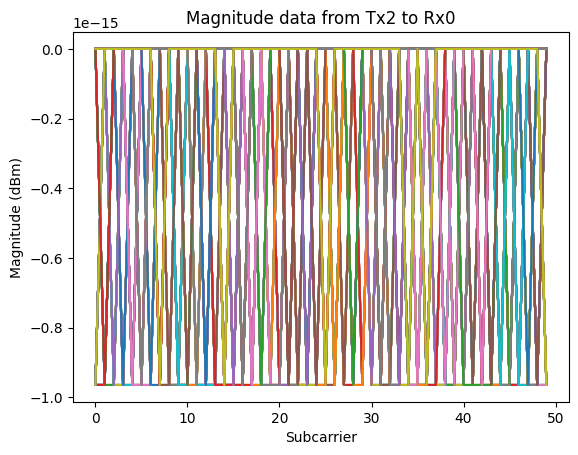

In [8]:
def plot_magnitude_data(data, tx, rx, normalize=False, ax=None, color='green', title=None, saveName=None):
  allData = {0: [[], []], 1: [[], []], 2: [[], []], 3: [[], []]}
  colors = ["red", "green", "blue", "purple"]
  newplot = False
  if ax == None:
    fig, ax = plt.subplots()
    newplot = True
  # ax.set(xlim=(-1, 3), ylim=(-1, 3))
  if title == None:
    title = f"Magnitude data from Tx{tx} to Rx{rx}"
  ax.set_title(title)
  ax.set_ylabel("Magnitude (dBm)")
  ax.set_xlabel("Subcarrier")
  num = 0
  for csi, t in data:
      subcarriers = np.arange(0, 50)
      magnitudes = []
      for subcarrier in range(0, 50):
        benchmark = csi[subcarrier, 0, tx]
        data = csi[subcarrier, rx, tx]
        if normalize:
           data /= benchmark
        magnitude = 20*np.log10(np.abs(data))
        magnitudes.append(magnitude)
      ax.plot(subcarriers, magnitudes, alpha=1)
      num += 1
  if (saveName == None and newplot):
    print("SHOWING2")
    plt.show()
  elif saveName != None:
    plt.savefig(saveName)

def plot_magnitude(bag, tx, rx, normalize=False, ax=None, color='green', title=None, saveName=None):
  data = []
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      data.append((pipeline_utils.extract_csi(msg, comp), t))
  plot_magnitude_data(data, tx, rx, normalize, ax, color, title, saveName)
      
# for rx in range(0, 4):
plot_magnitude(bags[2], 2, 0, True)

In [9]:
def phase_amplidude_2x4(bag, figure_title="", phaseRange=None, magRange=None, normalize=False):
  fig, axs = plt.subplots(2, 4, figsize=(10, 6),
                            sharey=False, layout='constrained')
  colors = ["red", "green", "blue", "purple"]
  fig.suptitle(figure_title)
  
  for rx in range(0, 4):
    if phaseRange != None:
      axs[0, rx].set_ylim(phaseRange)
    if magRange != None:
      axs[1, rx].set_ylim(magRange)
    plot_phase(bag, 2, rx, normalize, axs[0, rx], colors[rx], f"Rx{rx}")
    plot_magnitude(bag, 2, rx, False, axs[1, rx], colors[rx], "")
  plt.show()
# for bag, pos in zip(bags, positions):
  # phase_amplidude_2x4(bag, f"CSI data from Tx{2}, Position ({pos[0]}, {pos[1]}, {pos[2]})", (-10, 10), (100, 150))

In [10]:
# phase_amplidude_2x4(testBag2, "CSI data from Tx2", (-15, 15), (100, 160))

In [11]:
def plot_subcarrier_phase(bag, tx, subcarrier, title=None, saveName=None):
  allData = {0: [[], []], 1: [[], []], 2: [[], []], 3: [[], []]}
  colors = ["red", "green", "blue", "purple"]
  fig, ax = plt.subplots()
  if title == None:
    title = f"Phase data from Tx{tx}"
  plt.title(title)
  plt.ylabel("Phase (radians)")
  plt.xlabel("Time")
  num = 0
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      for i in range(0, 4):
          # for subcarrier in range(0, 50):
        benchmark = csi[subcarrier, 0, tx]
        data = csi[subcarrier, i, tx]
        phase = np.abs(data)
        allData[i][0].append(t.to_sec())
        allData[i][1].append(phase)
      num += 1
      # break
            # print(np.abs(csi[subcarrier, i, j]))
      # return
  for i in range(0, 4):
    ax.scatter(allData[i][0], np.unwrap(allData[i][1]), c=colors[i], label=f"Rx{i}", s=1, alpha=1)
    # ax.scatter(allData[i][0], np.array(allData[i][1]) + 360, c=colors[i], label=f"Rx{i}", s=1, alpha=0.2)
    # ax.scatter(allData[i][0], np.array(allData[i][1]) - 360, c=colors[i], label=f"Rx{i}", s=1, alpha=0.2)
  # ax.scatter(reals, imags, c=colors * num, s=1)
  ax.legend()
  if (saveName == None):
    print("SHOWING5")
    plt.show()
  else:
    plt.savefig(saveName)
# for i in range(0, 10):
  # plot_subcarrier_phase(bag4, 2, i, title=f"CSI data from Tx{2}, Subcarrier {i}, Position (-2, 0, 0)")

In [12]:
def plot_csi_data_phases_unwrap(bag, tx, title=None, saveName=None):
  allData = {0: [[], []], 1: [[], []], 2: [[], []], 3: [[], []]}
  colors = ["red", "green", "blue", "purple"]
  fig, ax = plt.subplots()
  # ax.set(xlim=(-1, 3), ylim=(-1, 3))
  if title == None:
    title = f"Phase data from Tx{tx}"
  plt.title(title)
  plt.ylabel("Phase (degrees)")
  plt.xlabel("Subcarrier")
  num = 0
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      # print(np.shape(csi))
      for i in range(0, 4):
          for subcarrier in range(0, 50):
            benchmark = csi[subcarrier, 0, tx]
            data = csi[subcarrier, i, tx] / benchmark
            phase = np.angle(data, True)
            allData[i][0].append(subcarrier)
            allData[i][1].append(phase)
      num += 1
            # print(np.abs(csi[subcarrier, i, j]))
      # return
  for i in range(0, 2):
    ax.scatter(allData[i][0], np.unwrap(allData[i][1]), c=colors[i], label=f"Rx{i}", s=1, alpha=0.2)
    # ax.scatter(allData[i][0], np.array(allData[i][1]) + 360, c=colors[i], label=f"Rx{i}", s=1, alpha=0.2)
    # ax.scatter(allData[i][0], np.array(allData[i][1]) - 360, c=colors[i], label=f"Rx{i}", s=1, alpha=0.2)
  # ax.scatter(reals, imags, c=colors * num, s=1)
  ax.legend()
  if (saveName == None):
    plt.show()
  else:
    plt.savefig(saveName)

  plot_csi_data_phases_unwrap(bags[2], 2, title=f"CSI data from Tx{2} and subcarrier {1}, Position (-2, 0, 0)")

In [13]:
timestamps = []
with open("./csiTesting/poses227.txt") as f:
  for line in f.readlines():
    if line[0] == "#":
      continue
    parts = list(map(lambda x: float(x), line.split(" ")))
    if (parts[0] < 1709065780):
      continue
    timestamps.append((parts[0], parts[1], parts[2], parts[3]))
timestamps

[(1709065781.896945, 0.039595, -0.332028, 0.456638),
 (1709065782.297004, 0.054194, -0.358971, 0.535839),
 (1709065782.697064, 0.066182, -0.386436, 0.615412),
 (1709065783.097123, 0.079547, -0.411318, 0.692632),
 (1709065783.497182, 0.092799, -0.436339, 0.770325),
 (1709065783.897241, 0.105325, -0.460701, 0.845153),
 (1709065784.2973, 0.117993, -0.483907, 0.917431),
 (1709065784.697359, 0.132265, -0.509761, 0.998103),
 (1709065785.097418, 0.145696, -0.537421, 1.080866),
 (1709065785.497477, 0.158365, -0.563756, 1.157648),
 (1709065785.897536, 0.171778, -0.588243, 1.232908),
 (1709065786.297596, 0.183561, -0.612629, 1.304132),
 (1709065786.697654, 0.197679, -0.64015, 1.386074),
 (1709065787.097713, 0.209277, -0.661705, 1.453026),
 (1709065787.697802, 0.220554, -0.683711, 1.521043),
 (1709065788.097861, 0.23206, -0.70465, 1.585127),
 (1709065788.49792, 0.243399, -0.725064, 1.648445),
 (1709065788.897979, 0.253513, -0.743979, 1.707526),
 (1709065789.298038, 0.263577, -0.763338, 1.765908),

In [14]:
testBag2 = rosbag.Bag("./csiTesting/roomba1_2024-02-27-14-26-43.bag")

def interpolate_data(bag, timestamps):
  # list of tuples (time, x, y, z, csi, rssi)
  data = []
  upperIndex = 1
  for (topic, msg, t), k in zip(tqdm.tqdm(bag.read_messages('/csi')), bag):
    t = t.to_sec()
    if (t < timestamps[0][0]):
      continue
    if (t > timestamps[-1][0]):
      break
    if (t >= timestamps[upperIndex][0]):
      upperIndex += 1
    lowerIndex = upperIndex - 1
    lowerTime, lowerX, lowerY, lowerZ = timestamps[lowerIndex]
    upperTime, upperX, upperY, upperZ = timestamps[upperIndex]
    frac = (t - lowerTime) / (upperTime - lowerTime)
    x = lowerX + frac * (upperX - lowerX)
    y = lowerY + frac * (upperY - lowerY)
    z = lowerZ + frac * (upperZ - lowerZ)
    csi = pipeline_utils.extract_csi(msg, comp)
    rssi = k[1].rssi
    data.append((t, x, y, z, csi, rssi))
  return data
allData = interpolate_data(testBag2, timestamps)
# print(timeToPositionToCSI[0])
for i in allData:
  print(i[5])
# print(allData[0][5])

0it [00:00, ?it/s]

2057it [00:00, 7798.05it/s] 

-50
-48
-49
-52
-51
-49
-52
-50
-50
-49
-49
-50
-54
-51
-54
-53
-54
-52
-52
-51
-52
-54
-54
-55
-53
-56
-50
-50
-52
-51
-50
-50
-51
-49
-48
-51
-51
-51
-51
-49
-49
-52
-52
-52
-52
-51
-53
-52
-51
-54
-53
-56
-51
-50
-47
-50
-49
-50
-50
-52
-51
-51
-53
-51
-55
-51
-51
-48
-47
-51
-49
-48
-48
-51
-47
-51
-55
-53
-50
-48
-53
-50
-52
-52
-51
-49
-47
-48
-45
-44
-47
-46
-45
-47
-46
-46
-46
-45
-44
-44
-44
-46
-45
-45
-46
-47
-47
-46
-46
-48
-47
-49
-50
-47
-48
-46
-46
-46
-46
-46
-45
-45
-45
-44
-44
-44
-44
-43
-43
-44
-43
-44
-44
-44
-44
-44
-44
-44
-43
-43
-43
-44
-44
-43
-44
-44
-44
-44
-45
-46
-46
-45
-46
-47
-47
-48
-47
-47
-46
-48
-49
-49
-47
-46
-45
-44
-44
-48
-49
-47
-45
-50
-51
-52
-51
-52
-52
-52
-54
-52
-51
-53
-51
-48
-50
-49
-49
-49
-50
-48
-48
-51
-50
-51
-50
-53
-54
-51
-50
-56
-54
-51
-54
-51
-50
-51
-50
-50
-51
-50
-51
-52
-55
-50
-51
-49
-50
-50
-51
-51
-51
-54
-51
-54
-50
-53
-55
-55
-50
-50
-52
-49
-52
-54
-54
-52
-51
-53
-54
-54
-53
-53
-53
-52
-52
-48
-51
-54
-52
-50


2057it [00:00, 7642.46it/s] 


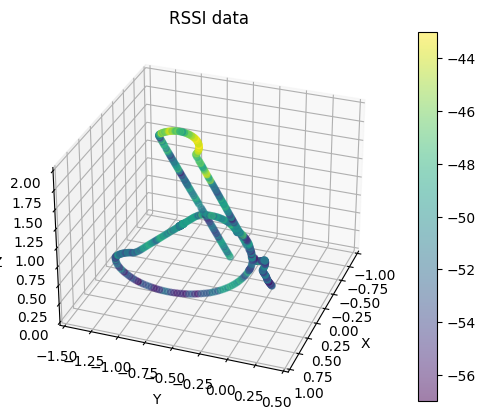

In [15]:
def consolidate(data, n=10):
  newData = []
  for i in range(0, len(data), n):
    sum = 0
    for j in range(0, n):
      if (i + j >= len(data)):
        n = j
        break
      sum += data[i+j]
    newData.append(sum / n)
  return newData

def consolidateSOA(data, n=10):
  newData = []
  for d in data:
    newData.append(consolidate(d, n))
  return newData


def get_median_magnitude(csi, rx):
  sum = 0
  allMagnitudes = [csi[subcarrier, rx, 2] for subcarrier in range(0, 50)]
  allMagnitudes.sort()
  return 20*np.log10(np.abs(allMagnitudes[25]))

def get_mean_magnitude(csi, rx):
  sum = 0
  allMagnitudes = [csi[subcarrier, rx, 2] for subcarrier in range(0, 50)]
  for data in allMagnitudes:
    sum += 20*np.log10(np.abs(data))
    # sum += np.abs(data)
  return sum / 50

def plot_3d_data(plotData, i=None, ax=None, title=None, savename=None):
  fig = None
  newPlot = False
  if ax == None:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    newPlot = True
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
  ax.set_xlim(-1, 1)
  ax.set_ylim(-1.5, 0.5)
  ax.set_zlim(0, 2)
  if title == None:
    # title = f"Magnitude of CSI data from Tx2 (Mean over subcarriers)"
    title = f"RSSI data"
  ax.set_title(title)
  sc = ax.scatter(plotData[0], plotData[1], plotData[2], c=plotData[3], cmap="viridis", alpha=0.5)
  if i != None:
    ax.scatter(plotData[0][i], plotData[1][i], plotData[2][i], color="red", s=100)
  if fig != None:
    fig.colorbar(sc)
  # ax.set_box_aspect((1,1,1))
  ax.azim = 20
  if (savename == None and newPlot):
    plt.show()
  elif savename != None:
    plt.savefig(savename)

def get_plot_data(combinedData):
  plotData = [[], [], [], []]
  for time, x, y, z, csi, rssi in combinedData:
    # magnitude = (get_mean_magnitude(csi, 0) + get_mean_magnitude(csi, 1) + get_mean_magnitude(csi, 2) + get_mean_magnitude(csi, 3))/4
    magnitude = rssi
    plotData[0].append(x)
    plotData[1].append(y)
    plotData[2].append(z)
    plotData[3].append(magnitude)
  return plotData

def plot_csi_data_3d(bag, timestamps, ax=None, title=None, savename=None):
  combinedData = interpolate_data(bag, timestamps)
  plotData = get_plot_data(combinedData)
  plotData = np.array(consolidateSOA(plotData, 1))
  plot_3d_data(plotData, ax, title, savename)

plot_csi_data_3d(testBag2, timestamps)


In [16]:
def generate_frame(consolidatedData, frame, phaseRange=None, magRange=None, saveName=None):
  frameSize = 3
  fig = plt.figure(figsize=(15, 5))
  axs = [[], []]
  for i in range(0, 4):
    axs[0].append(fig.add_subplot(2, 6, i + 1))
    axs[1].append(fig.add_subplot(2, 6, i + 7))
  thingy = fig.add_subplot(1, 3, 3, projection='3d')
  thingy.set_title("OOPS")
  fig.suptitle("CSI data from Tx2")
  data = []
  for i in range(0, frameSize):
    part = consolidatedData[frame * frameSize + i]
    # print(part)
    data.append((part[4], part[0]))
  for rx in range(0, 4):
    if phaseRange != None:
      axs[0][rx].set_ylim(phaseRange)
    if magRange != None:
      axs[1][rx].set_ylim(magRange)
    ylabel = True
    if rx > 0:
      axs[0][rx].set_yticklabels([])
      axs[1][rx].set_yticklabels([])
      ylabel = False
    plot_phase_data(data, 2, rx, False, axs[0][rx], "helli", f"Rx{rx}", ylabel=ylabel, xlabel=False)
    plot_magnitude_data(data, 2, rx, False, axs[1][rx], "hello", "")
  plot_3d_data(np.array(consolidateSOA(get_plot_data(consolidatedData), frameSize)), i=frame, ax=thingy, title="Position")
  if saveName == None:
    print("SHOWING")
    plt.show()
  else:
    plt.savefig(saveName)
    plt.close()


generate_frame(allData, 2, (-15, 15), (100, 160), "Testimage.png")
numFrames = int(len(allData) / 3)
# for i in range(0, numFrames):
  # generate_frame(allData, i, (-15, 15), (100, 160), f"./consolidatedFrames/frame{i}.png")

In [17]:
# code = cv2.VideoWriter_fourcc(*'M4S2')
# out = cv2.VideoWriter("newVideo.mp4", code, 5, (1500, 500))
# for i in range(0, numFrames):
#   frame = cv2.imread(f"./consolidatedFrames/frame{i}.png")
#   out.write(frame)
# out.release()


In [18]:
def draw_channel_image_4x4(channel_1, channel_2):
    print("afad")
    num_tx_slots = channel_1.shape[2]
    num_rx_slots = channel_1.shape[1]
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    fig, axs = plt.subplots(num_tx_slots*2, num_rx_slots, figsize=(24, 24),
                            gridspec_kw={'height_ratios': [1, 0.7] * num_tx_slots})
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    amplitude_1 = (np.abs(channel_1))
    amplitude_2 = (np.abs(channel_2))
    min_amp = min(np.min(amplitude_1), np.min(amplitude_2))
    max_amp = max(np.max(amplitude_1), np.max(amplitude_2))
    phase_1 = np.unwrap(np.angle(channel_1))
    phase_2 = np.unwrap(np.angle(channel_2))
    min_phase = min(np.min(phase_1), np.min(phase_2))
    max_phase = max(np.max(phase_1), np.max(phase_2))
    print(min_phase, max_phase)
    for i in range(0, num_tx_slots*2, 2):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0, f"Tx Ant {i//2}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude (dB)")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            # axs[i, j].plot(20*np.log10(np.abs(channel_1[:, j, i//2])),
            #                label="LOS")
            axs[i, j].plot((np.abs(channel_1[:, j, i//2])),
                           label="LOS")
            # axs[i, j].plot(20*np.log10(np.abs(channel_2[:, j, i//2])),
                        #    label="NLOS")
            axs[i, j].legend()
            # plot phase
            axs[i+1, j].set_xlabel("Subcarrier indices")
            axs[i+1, j].set_ylabel("Phase (deg)")
            axs[i+1, j].set_ylim(min_phase, max_phase)
            axs[i+1, j].set_yticks(y_tick_positions)
            axs[i+1, j].set_yticklabels(y_tick_labels)
            # don't wrap 
            # axs[i+1, j].plot(np.angle(channel_1[:, j, i//2]),
            #                  label="LOS")
            # axs[i+1, j].plot(np.angle(channel_2[:, j, i//2]),
            #                  label="NLOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_1[:, j, i//2])),
                             label="LOS")
            axs[i+1, j].plot(np.unwrap(np.angle(channel_2[:, j, i//2])),
                             label="NLOS2")
            axs[i+1, j].legend() 
    fig.set_tight_layout(True)   
    plt.savefig('40 157 los vs nlos.png')
    plt.show()
   

def draw_amplitude_4x4(channel, figure_title=""):
    print("afad")
    num_tx_slots = channel.shape[2]
    num_rx_slots = channel.shape[1]
    fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    amplitude = (np.abs(channel))
    min_amp = np.min(amplitude)
    max_amp = np.max(amplitude)
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
            if i == 0:
                # Place Rx antenna labels at the top
                axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
            if j == 0:
                # Place Tx antenna labels on the left 
                axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                               rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                
            # plot magnitude
            axs[i, j].set_xlabel("Subcarrier indices")
            axs[i, j].set_ylabel("Magnitude")
            axs[i, j].set_ylim(min_amp-10, max_amp+10)
            axs[i, j].plot((np.abs(channel[:, j, i])),
                           label="LOS")
            axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    plt.show()

In [19]:
def draw_amplitudes_4x4(bag, figure_title="", average=False, fig=None, axs=None, show=True, min_a=None, max_a=None):
    print("afad")
    num_tx_slots = 4
    num_rx_slots = 4
    tx_ant_labels = [f"Tx Ant {i}" for i in range(num_tx_slots)]
    rx_ant_labels = [f"Rx Ant {i}" for i in range(num_rx_slots)]
    if (fig is None):
        fig, axs = plt.subplots(num_tx_slots, num_rx_slots, figsize=(24, 24),
                            sharey=True, layout='constrained')
        fig.suptitle(figure_title, fontsize=24)
    # add tick for phase plot
    y_tick_positions = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    y_tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    # amplitude = (np.abs(channel))
    min_amp = 1000
    max_amp = -1000
    # phase = np.unwrap(np.angle(channel))
    # min_phase = np.min(phase)
    # max_phase = np.max(phase)
    
    for i in range(num_tx_slots):
        for j in range(num_rx_slots):
                if i == 0:
                    # Place Rx antenna labels at the top
                    axs[i, j].set_title(f"Rx Ant {j}", fontsize=16)
                if j == 0:
                # Place Tx antenna labels on the left 
                    axs[i, j].text(-0.2, 0.5, f"Tx Ant {i}", va='center', ha='center',
                rotation='vertical', transform=axs[i, 0].transAxes, fontsize=16)
                k = 20
                if not average:
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], comp, False, valid_tx_ant)
                        amplitude = (np.abs(channel))
                        min_amp = min(np.min(amplitude), min_amp)
                        max_amp = max(np.max(amplitude), max_amp)
                        # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                        axs[i, j].plot((amplitude[:, j, i]), label="l")
                        k += 1
                        if k == 30:
                            break
                else:
                    totalValues = None
                    for data in bag:
                        channel = pipeline_utils.extract_csi(data[1], None, False, valid_tx_ant)
                        if totalValues is None:
                            totalValues = channel
                        else:
                            totalValues += channel
                        k += 1
                        if k == 30:
                            break
                    amplitude = (np.abs(totalValues))
                    min_amp = min(np.min(amplitude), min_amp)
                    max_amp = max(np.max(amplitude), max_amp)
                    # axs[i, j].plot((np.abs(channel[:, j, i])), label="l")
                    axs[i, j].plot((amplitude[:, j, i]), label="l")
                     

                    
                # plot magnitude
                axs[i, j].set_xlabel("Subcarrier indices")
                axs[i, j].set_ylabel("Magnitude")
                if (min_a != None):
                     min_amp = min_a
                if (max_a != None):
                     max_amp = max_a
                mi, ma = axs[i, j].get_ylim()
                axs[i, j].set_ylim(min(mi,min_amp-10), max(ma, max_amp+10))

                # axs[i, j].legend()
    fig.set_tight_layout(True)   
    # plt.savefig('40 157 los vs nlos.png')
    if show:
        plt.show()

In [20]:
def compare_amplitudes_4x4(bags, figure_title=""):
    fig, axs = plt.subplots(4, 4, figsize=(24, 24),
                            sharey=True, layout='constrained')
    fig.suptitle(figure_title, fontsize=24)
    for bag in bags:
        print("drawing bag")
        draw_amplitudes_4x4(bag, "", True, fig, axs, False)
    for i in range(4):
        for j in range(4):
            axs[i, j].legend([f"Location {k}" for k in range(1, 6)])
    plt.show()

In [21]:
# headon = rosbag.Bag("../HeadOn.bag")
# ninetydeg = rosbag.Bag("../90deg2.bag")
# fortyfive = rosbag.Bag("../45deg.bag")
# nfortyfive = rosbag.Bag("../n45deg.bag")
#smooth over last n packets according to algo
smoothing_window = 1
#aoa search space
theta_space = np.linspace(-np.pi/2,np.pi/2,360)
#tof search space
tof_space = np.linspace(-40,40,240)

#antenna position (interleaved x-y), see antennas.md
rx_pos = np.asarray([0,  0,
    0,  -0.06,
    0,  -0.03,
    0,  -0.09]).reshape((-1,2))
channels = {}
times = {}
aoas = {}
rssis = {}
profs = {}
aoa_sensors = {}


In [22]:
def get_angle_profiles(bag, algorithm, subcarriers = range(0, 50), txs=[0, 1, 2, 3]):
  """Returns a list of [(time, [angles], [profile])] for each packet

  Arguments:
  - bag: The bag with csi data to get the angle profiles from
  - algorithm: The algorithm to use to get the angle likelihood ("music", "aoa", "fft")
  - subcarriers: The subcarriers to use for the algorithm. Should be a subset of the integers from 0 to 49
  """
  print("ALGORITHM:", algorithm)
  num = 0
  data = []
  aoa_sensor = None
  if algorithm == "music":
    aoa_sensor = transform_utils.music_aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
    aoa_sensor.prof_dim = 4
  elif algorithm == "aoa":
    aoa_sensor = transform_utils.aoa_sensor_1d(rx_pos, theta_space, smoothing_window)
  elif algorithm == "fft":
    aoa_sensor = transform_utils.fft_aoa_sensor(rx_pos, theta_space, smoothing_window)
  elif algorithm == "othermusic":
    tofs = np.linspace(-40, 40, 180)
    aoa_sensor = transform_utils.full_music_aoa_sensor(rx_pos, theta_space, tofs, smoothing_window)
  for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      #assuming this does not change
      if algorithm == "othermusic":
        res = aoa_sensor(csi, (msg.chan, msg.bw*1e6))
        # print("Channel:", msg.chan, " BW:", msg.bw*1e6)
      elif algorithm == "aoa" or algorithm == "music":
        res = aoa_sensor.run(csi, (msg.chan, msg.bw*1e6), subcarriers=subcarriers, txs=txs)
      else:
        res = aoa_sensor.run(csi,(msg.chan,msg.bw*1e6), subcarriers=subcarriers)
      num += 1
      data.append((t.to_sec(), theta_space * 180 / np.pi, res[1]))
  print("Packets:", num)
  return data

def plot_angle_profiles(data, title, ax=None, tof_indices = None, savename=None, **kwargs):
  """Plots a list of [(time, [angles], [profile])]"""
  newPlot = False
  if ax == None:
    fig, ax = plt.subplots()
    newPlot = True
  ax.set_title(title)
  if 'ylabel' in kwargs and kwargs['ylabel']:
    ax.set_ylabel("Angle (degrees)")
  if 'xlabel' in kwargs and kwargs['xlabel']:
    ax.set_xlabel("Time")
  for time, angles, profile in data:
    if tof_indices is not None:
      start_i = tof_indices[0]
      end_i = tof_indices[1]
      ax.scatter([time] * len(angles), angles, c=np.max(profile[:, start_i:end_i], axis=1), s=10)
    else:
      ax.scatter([time] * len(angles), angles, c=profile, s=10)
  if savename is not None:
    plt.savefig(savename)
  elif newPlot:
    plt.show()

def plot_angle_distance_profile(profile, title="", ax=None, savename=None):
  newPlot = False
  if ax == None:
    fig, ax = plt.subplots()
    newPlot = True
  ax.set_title(title)
  ax.set_xlabel("Angle (degrees)")
  ax.set_ylabel("Distance (meters)")
  for i, angleArray in enumerate(profile):
    for (j, value) in enumerate(angleArray):
      angle = i - 180
      distance = j * 80/180 - 40
      ax.scatter(angle, distance, c=value, s=10)
      if j == 10:
        break
    if i == 10:
      break
  if savename is not None:
    plt.savefig(savename)
  elif newPlot:
    plt.show()
  

In [23]:
headOnData = rosbag.Bag("HeadOn_2024-03-13-12-17-17.bag")
allProfiles = get_angle_profiles(headOnData, "othermusic")
profile = allProfiles[4][2]

ALGORITHM: othermusic


220it [00:13, 16.44it/s]

Packets: 220


In [24]:
# plot_angle_distance_profile(profile)
# print(np.shape(profile))
headOnData = rosbag.Bag("HeadOn_2024-03-13-12-17-17.bag")
# headOnData[2][1].rssi
for k, l in zip(headOnData, [0, 1, 2, 3]):
  print(k[1].rssi, l)
  # break

-48 0
-48 1
-48 2
-48 3


In [32]:
def compare_angle_profiles(bags, titles, algorithm="aoa", savename=None):
    widthSize = len(bags)
    
    if (len(titles) != widthSize):
        raise RuntimeError(f"titles did not have the same length as bags (len(titles) = {len(titles)}, len(bags) = {len(bags)})")
    fig, axs = plt.subplots(5, widthSize, figsize=(5*widthSize, 20))
    for i in range(0, 5):
        if (i < 1):
            tx = [0, 1, 2, 3]
        else:
            tx = [i - 1]
        print("TX:", tx)
        # fig.suptitle(f"Tx {tx}")
        for (j, bag) in enumerate(bags):
            xlabel = i == 4
            ylabel = j == 0
            angleProfile = get_angle_profiles(bag, algorithm, txs=tx)
            if (widthSize == 1):
                ax = axs[i]
            else:
                ax = axs[i, j]
            plot_angle_profiles(angleProfile, f"Tx {tx} {titles[j]}", ax, xlabel=xlabel, ylabel=ylabel)
    if savename == None:
        plt.show()
    else:
        plt.savefig(savename)


ALGORITHM: music


386it [00:00, 2783.48it/s]


Packets: 386
TX: [0, 1, 2, 3]
ALGORITHM: music


269it [00:00, 2901.24it/s]


Packets: 269
TX: [0]
ALGORITHM: music


269it [00:00, 3064.35it/s]

Packets: 269


TX: [1]
ALGORITHM: music


269it [00:00, 2959.33it/s]

Packets: 269


TX: [2]
ALGORITHM: music


269it [00:00, 3316.28it/s]

Packets: 269


TX: [3]
ALGORITHM: music


269it [00:00, 3254.26it/s]

Packets: 269


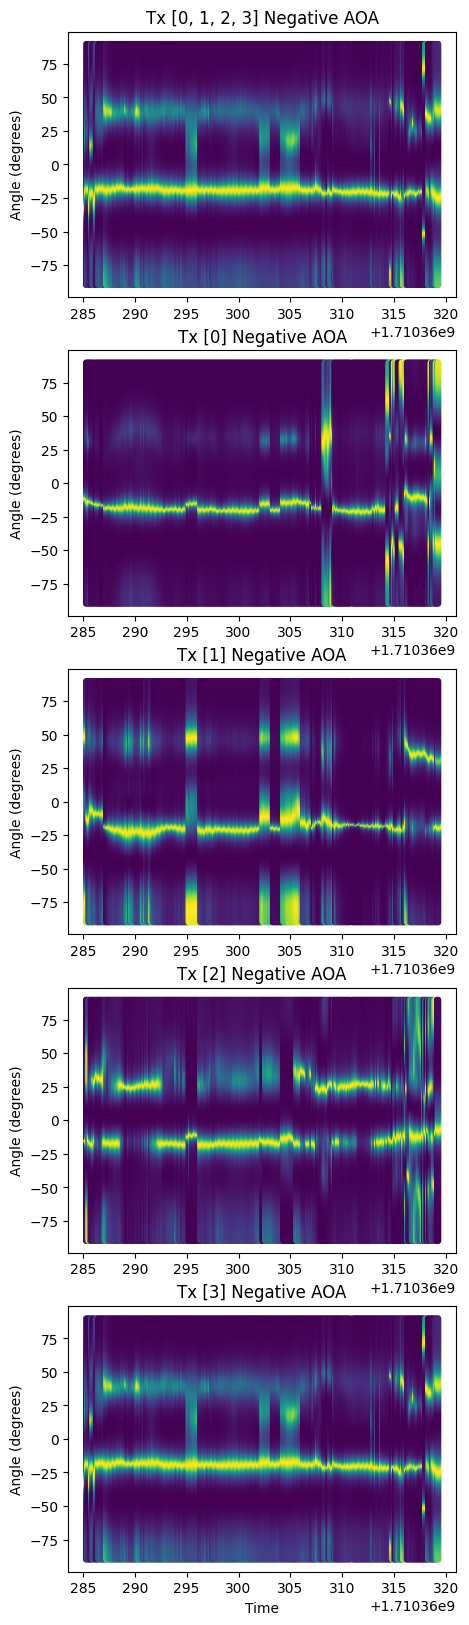

In [33]:
compensationData = rosbag.Bag("compensation_2024-03-13-11-15-56.bag")

test2 = rosbag.Bag("test2_2024-03-13-11-33-56.bag")


rotationData = rosbag.Bag("rotationData_2024-03-13-12-09-44.bag")
rotationProfile = get_angle_profiles(rotationData, "music", txs=[0, 1, 2, 3])

closeRotationData = rosbag.Bag("rotationDataClose_2024-03-13-12-14-50.bag")

headOnData = rosbag.Bag("HeadOn_2024-03-13-12-17-17.bag")
headOnBlockedData = rosbag.Bag("HeadOnBlocked_2024-03-13-12-29-50.bag")
headOnFullBlockedData = rosbag.Bag("HeadOnFullBlocked_2024-03-13-12-40-33.bag")
# draw_amplitudes_4x4(headOnBlockedData)

# plot_angle_profiles(rotationProfile, "All tx")

bags = [rosbag.Bag(f"csiTesting/experiment2/AOA{x}.bag") for x in ['-2', '0', '+']]
# titles = ["Negative AOA", "Zero AOA", "Positive AOA"]
bags = [bags[0]]
titles = ["Negative AOA"]
# bags = [headOnData, headOnBlockedData, headOnFullBlockedData]
# titles = ["Head On", "Head On Blocked", "Head On Full Blocked"]
compare_angle_profiles(bags, titles, "music")

# for tx in range(-1, 4):
#     if (tx < 0):
#         tx = [0, 1, 2, 3]
#     else:
#         tx = [tx]
#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
#     blocked = get_angle_profiles(headOnBlockedData, "music", txs=tx)

#     notBlocked = get_angle_profiles(headOnData, "music", txs=tx)

#     fullBlocked = get_angle_profiles(headOnFullBlockedData, "music", txs=tx)
    
#     plot_angle_profiles(notBlocked, f"Not Blocked Tx {tx}", ax0)

#     plot_angle_profiles(blocked, f"Blocked Tx {tx}", ax1)

#     plot_angle_profiles(fullBlocked, f"Full Blocked Tx {tx}", ax2)
#     plt.show()

0it [00:00, ?it/s]

375it [00:00, 3758.68it/s]
375it [00:00, 3950.49it/s]
375it [00:00, 4035.89it/s]
375it [00:00, 4015.89it/s]
375it [00:00, 4013.19it/s]
375it [00:00, 3971.65it/s]
375it [00:00, 4015.20it/s]
375it [00:00, 3953.49it/s]


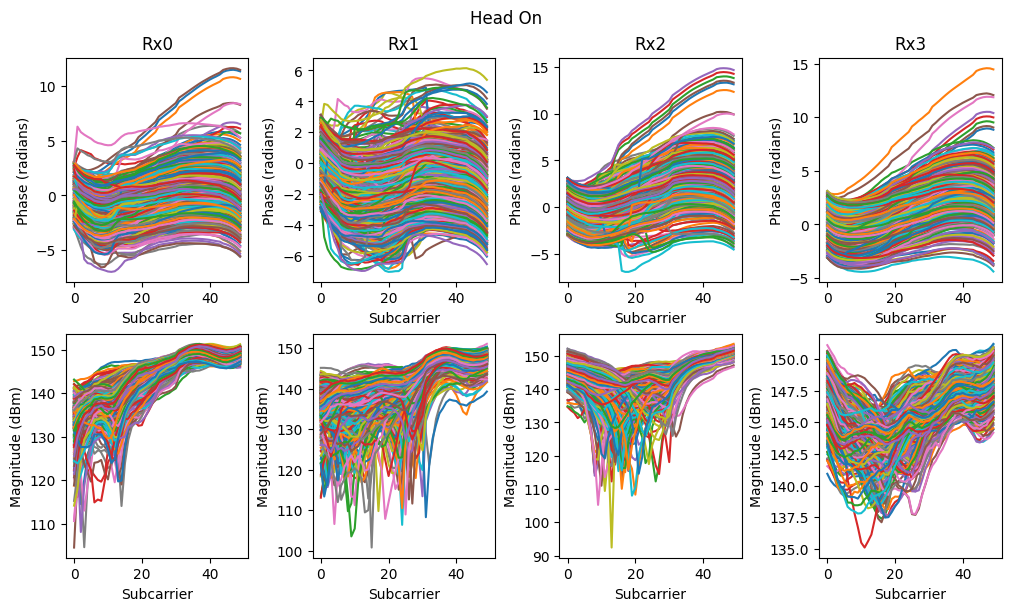

ALGORITHM: aoa


2209it [00:00, 3098.37it/s]


Packets: 2209


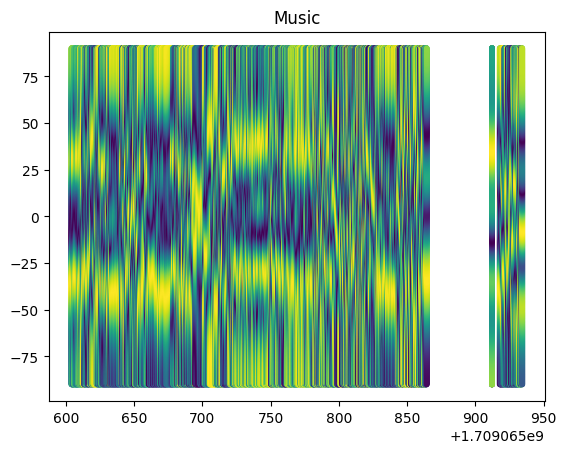

In [27]:
phase_amplidude_2x4(headOnFullBlockedData, "Head On")
p = get_angle_profiles(testBag2, "aoa")
plot_angle_profiles(p, "Music")
# music_aoa_sensor = transform_utils.music_aoa_sensor_1d(rx_pos, theta_space, smoothing_window)

In [28]:
from scipy.io import savemat
def generate_mat_file(bags, names, savename):
  mat_dict = {}
  for bag, name in zip(bags, names):
    data = []
    for topic, msg, t in tqdm.tqdm(bag.read_messages('/csi')):
      csi = pipeline_utils.extract_csi(msg, comp)
      data.append(csi)
    data = np.array(data)
    mat_dict[name] = data
  savemat(savename, mat_dict)

generate_mat_file([rosbag.Bag(f"csiTesting/experiment2/AOA{x}.bag") for x in ['-2', '0', '+']], ['negativeAOA', 'zeroAOA', 'positiveAOA'], "experiment2.mat")

269it [00:00, 3960.84it/s]
594it [00:00, 3971.25it/s]
684it [00:00, 3961.79it/s]
